In [1]:
# python - libraries
import sys
import os
from pathlib import Path
from operator import methodcaller

if not str(Path(os.getcwd()).parent) in sys.path:
    sys.path.append(str(Path(os.getcwd()).parent))

# torch
import torch
from torch import nn

# numpy
import numpy as np

# visualization
import matplotlib.pyplot as plt
## Image
import requests
import io
from PIL import Image


# helper module
try:
    import my_helper as helper
except :
    print("[INFO] Downloading helper function")
    import requests
    response = requests.get("https://raw.githubusercontent.com/Lashi0812/PyTorch2/master/my_helper.py")
    with open("my_helper.py","wb") as f:
        f.write(response.content)
    import my_helper as helper

# Cross Correlation

$$[\mathbf{H}]_{i, j} = u + \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} [\mathbf{V}]_{a, b}  [\mathbf{X}]_{i+a, j+b}.$$

In [2]:
def corr2d(X: torch.Tensor, K: torch.Tensor) -> torch.Tensor:
    """Compute 2D cross-correlation"""
    h, w = K.shape
    Y = torch.zeros(size=(X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i : i + h, j : j + w] * K).sum()
    return Y


In [3]:
X = torch.arange(0,9,dtype=torch.float).reshape(3,3)
K = torch.arange(0,4,dtype=torch.float).reshape(2,2)
H = corr2d(X,K)
H

tensor([[19., 25.],
        [37., 43.]])

# Convolution layer

In [4]:
class Conv2d(nn.Module):
    def __init__(self,kernel_size) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))
    
    def forward(self,x:torch.tensor):
        return corr2d(x,self.weight) + self.bias

# Object Edge detection

In [5]:
X = torch.ones((6,8))
X[:,2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

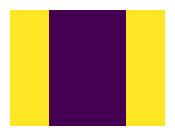

In [6]:
plt.figure(figsize=(2,2))
plt.imshow(X)
plt.axis("off");

In [7]:
edge_detector = torch.tensor([[1.0, -1.0]])
edge_detector

tensor([[ 1., -1.]])

In [8]:
H = corr2d(X,edge_detector)
H

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

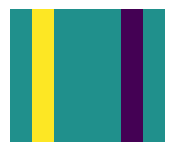

In [9]:
plt.figure(figsize=(2,2))
plt.imshow(H)
plt.axis("off");

# Learning the kernel

If you want we looking then we define kernel matrix like sobel edge detector.But the hard to define the kernel for the deep layer , so why cant the neural network learn the kernel.

Let try find kernel that produce H from X.

In [10]:
conv2d = nn.LazyConv2d(out_channels=1,kernel_size=(1,2),bias=False)

X = X.reshape((1,1,6,8))
H = H.reshape((1,1,6,7))
lr = 3e-2

c:\Users\Lenovo\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [11]:
for i in range(10):
    H_hat = conv2d(X)
    l = (H_hat - H)**2
    conv2d.zero_grad()
    l.sum().backward()
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i+1) %2 == 0:
        print(f"epoch {i+1} , loss ={l.sum():.2f}")

epoch 2 , loss =8.64
epoch 4 , loss =1.99
epoch 6 , loss =0.56
epoch 8 , loss =0.18
epoch 10 , loss =0.07


In [12]:
conv2d.weight.data.reshape((1,2))

#? this is same kernel we used earlier

tensor([[ 0.9609, -1.0127]])

# Padding

In general, if we add a total of $p_h$ rows of padding
(roughly half on top and half on bottom)
and a total of $p_w$ columns of padding
(roughly half on the left and half on the right),
the output shape will be

$$(n_h-k_h+p_h+1)\times(n_w-k_w+p_w+1).$$

This means that the height and width of the output
will increase by $p_h$ and $p_w$, respectively.

In many cases, we will want to set $p_h=k_h-1$ and $p_w=k_w-1$
to give the input and output the same height and width.
This will make it easier to predict the output shape of each layer
when constructing the network.
Assuming that $k_h$ is odd here,
we will pad $p_h/2$ rows on both sides of the height.


In [13]:
def comp_conv2d(conv2d:nn.Module,X:torch.Tensor)->torch.tensor:
    """Return output of conv2d layer by modify the input shape [b,c,h,w]"""
    X = X.reshape((1,1)+X.shape)
    Y = conv2d(X)

    return Y.squeeze()

In [14]:
X = torch.rand((8,8))
conv2d = nn.LazyConv2d(out_channels=1,kernel_size=3,padding=1)
comp_conv2d(conv2d,X).shape

torch.Size([8, 8])

In [15]:
conv2d = nn.LazyConv2d(out_channels=1,kernel_size=(5,3),padding=(2,1))
comp_conv2d(conv2d,X).shape

torch.Size([8, 8])

# Stride

$$\lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor.$$



In [16]:
conv2d = nn.LazyConv2d(out_channels=1,kernel_size=3,padding=1,stride=2)
comp_conv2d(conv2d,X).shape

torch.Size([4, 4])

In [17]:
conv2d = nn.LazyConv2d(out_channels=1,kernel_size=(3,5),padding=(0,1),stride=(3,4))
comp_conv2d(conv2d,X).shape

torch.Size([2, 2])

# Multi input Channel

Number of Kernel channel should be same as the input channel

kernel of shape --> [Cin * Kh * Kw]

In [18]:
X_channel0 = torch.arange(0,9,dtype=torch.float).reshape(3,3)
X_channel1 = torch.arange(1,10,dtype=torch.float).reshape(3,3)
X = torch.stack((X_channel0,X_channel1))
X

tensor([[[0., 1., 2.],
         [3., 4., 5.],
         [6., 7., 8.]],

        [[1., 2., 3.],
         [4., 5., 6.],
         [7., 8., 9.]]])

In [19]:
K_channel0 = torch.arange(0,4,dtype=torch.float).reshape(2,2)
K_channel1 = torch.arange(1,5,dtype=torch.float).reshape(2,2)
K = torch.stack((K_channel0,K_channel1))
K

tensor([[[0., 1.],
         [2., 3.]],

        [[1., 2.],
         [3., 4.]]])

In [20]:
def corr2d_multi_in(X,K):
    return sum(corr2d(x,k) for x,k in zip(X,K))

In [21]:
corr2d_multi_in(X,K)

tensor([[ 56.,  72.],
        [104., 120.]])

# Multi Output channel 

Now we stack number of kernel with same input channel as the number of output channel 

single kernel of shape --> [Cin * Kh * Kw]

Final kernel shape after stacking --> [Co * Cin * Kh * Kw]

In [22]:
def corr2d_multi_in_out(X,K):
    """kernel shape --> [Co * Cin * Kh * Kw]"""
    assert X.shape[0] == K.shape[1] , "Kernel should have same number of channel as input channel"
    return torch.stack([corr2d_multi_in(X,k) for k in K],dim=0)

In [23]:
# 3 different output channel
K = torch.stack((K,K+1,K+2),dim=0)
K.shape ,X.shape


(torch.Size([3, 2, 2, 2]), torch.Size([2, 3, 3]))

In [24]:
corr2d_multi_in_out(X,K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

# 1x1 Convolution kernel

Even though it loss the ability of Locality information, But if gather the information of single pixel present across the channel.

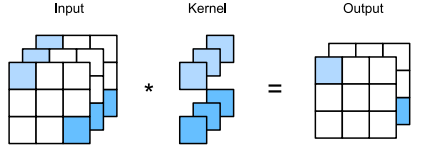


Input and output have same shape

In [25]:
def corr2d_multi_in_out_1x1(X,K):
    c_i ,h,w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i ,h*w))
    K = K.reshape((c_o,c_i))
    Y = torch.matmul(K,X)
    return Y.reshape((c_o,h,w))

In [26]:
X = torch.randn(size=(3,3,3))
K = torch.randn(size=(2,3,1,1))

In [27]:
Y1 = corr2d_multi_in_out_1x1(X,K)
Y2 = corr2d_multi_in_out(X,K)
Y1.shape ,Y2.shape

(torch.Size([2, 3, 3]), torch.Size([2, 3, 3]))

In [28]:
Y1

tensor([[[ 1.1871, -1.0291,  1.8334],
         [ 0.6520, -2.2396,  2.6665],
         [-0.6781,  0.7516, -0.5707]],

        [[-0.8911,  1.8803, -0.3313],
         [-0.9741,  1.5813,  0.1778],
         [-1.7064, -0.2767,  0.5998]]])

In [29]:
Y2

tensor([[[ 1.1871, -1.0291,  1.8334],
         [ 0.6520, -2.2396,  2.6665],
         [-0.6781,  0.7516, -0.5707]],

        [[-0.8911,  1.8803, -0.3313],
         [-0.9741,  1.5813,  0.1778],
         [-1.7064, -0.2767,  0.5998]]])

In [30]:
assert float(torch.abs(Y2-Y1).sum()) < 1e-6

# Pooling

In [31]:
def pool2d(X,pool_size,mode="max"):
    h,w = pool_size
    Y = torch.zeros(size=(X.shape[0]-h+1,X.shape[1]-w+1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            assert hasattr(torch,mode) , "try max or mean for pooling"
            f = methodcaller(mode,X[i:i+h,j:j+w])
            Y[i,j] = f(torch)
    return Y

In [32]:
X = torch.arange(0.,9.).reshape((3,3))
pool2d(X,(2,2))

tensor([[4., 5.],
        [7., 8.]])

In [33]:
pool2d(X,(2,2),mode="mean")

tensor([[2., 3.],
        [5., 6.]])